In [1]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.layers import (Layer, Input, Conv2D, BatchNormalization, Dropout, Dense, 
                                     Flatten, Reshape, Conv2DTranspose)
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

In [28]:
class Encoder:
    def __init__(self, num_conv_layers, encoder_conv_filters, encoder_strides,
                 encoder_output_dim, dropout_rate=None, input_dim=None, name='encoder', **kwargs):
        #super(Encoder, self).__init__(name=name, **kwargs)
        self.input_dim = input_dim
        self.dropout_rate = dropout_rate

        self.conv_layers = []
        for i in range(num_conv_layers):
            conv_layer = Conv2D(filters=encoder_conv_filters[i],
                                kernel_size=(3, 3),
                                strides=encoder_strides[i],
                                padding='same',
                                activation='relu',
                                name=f'encoder_conv_{i}')
            self.conv_layers.append(conv_layer)
            
        self.dense_layer = Dense(encoder_output_dim, name='encoder_output')
        
    
    def model(self):
        model_input = Input(shape=self.input_dim)
        return Model(model_input, self.call(model_input))
            

    def call(self, inputs):
        x = inputs
        for conv_layer in self.conv_layers:

            x = conv_layer(x)
        x = Flatten()(x)
        #self.shape_before_flat = K.int_shape(x)[1:] 
        x = self.dense_layer(x)
        return x
    
    
class Decoder:
    def __init__(self, num_conv_layers, decoder_conv_filters, shape_before_flat, 
                 decoder_strides, dropout_rate=None, input_dim=None, name='decoder', **kwargs):
        #super(Decoder, self).__init__(name=name, **kwargs)
        self.input_dim = input_dim
        self.dense = Dense(np.prod(shape_before_flat), activation='relu')
        self.reshape = Reshape(shape_before_flat)
        self.conv_layers = []
        for i in range(num_conv_layers - 1):
            conv_layer = Conv2DTranspose(filters=decoder_conv_filters[i],
                                         kernel_size=(3, 3),
                                         strides=decoder_strides[i],
                                         padding='same',
                                         activation='relu',
                                         name=f'decoder_conv_{i}')
            self.conv_layers.append(conv_layer)
            
        self.output_layer = Conv2DTranspose(filters=1,
                                            kernel_size=(3, 3),
                                            strides=1,
                                            padding='same',
                                            activation='sigmoid', 
                                            name=f'output_layer')
        
        
    def model(self):
        model_input = Input(shape=self.input_dim)
        return Model(model_input, self.call(model_input))

        
    def call(self, inputs):
        x = self.dense(inputs)
        x = self.reshape(x)
        for conv_layer in self.conv_layers:
            x = conv_layer(x)
        return self.output_layer(x)

In [29]:
num_conv_layers = 4
encoder_conv_filters = [64, 64, 64, 64]
encoder_output_dim=2
encoder_strides = [1,2,2,1]
input_dim=(28, 28, 1)

encoder_model = Encoder(num_conv_layers=num_conv_layers, 
                        encoder_conv_filters=encoder_conv_filters, 
                        encoder_output_dim=encoder_output_dim, 
                        encoder_strides=encoder_strides,
                        input_dim=input_dim)
encoder_model.model().summary()

Model: "functional_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder_conv_0 (Conv2D)      (None, 28, 28, 64)        640       
_________________________________________________________________
encoder_conv_1 (Conv2D)      (None, 14, 14, 64)        36928     
_________________________________________________________________
encoder_conv_2 (Conv2D)      (None, 7, 7, 64)          36928     
_________________________________________________________________
encoder_conv_3 (Conv2D)      (None, 7, 7, 64)          36928     
_________________________________________________________________
flatten_4 (Flatten)          (None, 3136)              0         
_________________________________________________________________
encoder_output (Dense)       (None, 2)               

In [30]:
num_conv_layers = 4
decoder_conv_filters = [64, 64, 64, 64]
encoder_output_dim=2
decoder_strides = [1,2,2,1]
input_dim=(2,)

decoder_model = Decoder(num_conv_layers = num_conv_layers, 
                        decoder_conv_filters = decoder_conv_filters, 
                        shape_before_flat = (7, 7, 64), 
                        decoder_strides = decoder_strides,
                        input_dim=input_dim,
                        dropout_rate=None, 
                        name='decoder')
decoder_model.model().summary()

Model: "functional_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 2)]               0         
_________________________________________________________________
dense_4 (Dense)              (None, 3136)              9408      
_________________________________________________________________
reshape_4 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
decoder_conv_0 (Conv2DTransp (None, 7, 7, 64)          36928     
_________________________________________________________________
decoder_conv_1 (Conv2DTransp (None, 14, 14, 64)        36928     
_________________________________________________________________
decoder_conv_2 (Conv2DTransp (None, 28, 28, 64)        36928     
_________________________________________________________________
output_layer (Conv2DTranspos (None, 28, 28, 1)       

In [33]:
encoder_input = Input(shape=(28, 28, 1))
encoder_output = encoder_model.call(encoder_input)
decoder_output = decoder_model.call(encoder_output)

model = Model(encoder_input, decoder_output)

model.summary()

Model: "functional_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder_conv_0 (Conv2D)      (None, 28, 28, 64)        640       
_________________________________________________________________
encoder_conv_1 (Conv2D)      (None, 14, 14, 64)        36928     
_________________________________________________________________
encoder_conv_2 (Conv2D)      (None, 7, 7, 64)          36928     
_________________________________________________________________
encoder_conv_3 (Conv2D)      (None, 7, 7, 64)          36928     
_________________________________________________________________
flatten_6 (Flatten)          (None, 3136)              0         
_________________________________________________________________
encoder_output (Dense)       (None, 2)               

In [36]:
num_conv_layers = 4
conv_units = 64
encoder_output_dim=2
strides = [1,2,2,1]
input_dim=(28, 28, 1)
dropout_rate=0.2

encoder_input = Input(shape=input_dim)
x = encoder_input
for i in range(num_conv_layers):
    conv_layer = Conv2D(filters=conv_units,
                        kernel_size=(3, 3),
                        strides=strides[i],
                        padding='same',
                        activation='relu',
                        name=f'encoder_conv_{i}')
    x = conv_layer(x)
    #x = BatchNormalization()(x)
    #x = Dropout(rate=dropout_rate)(x)

shape_before_flat = K.int_shape(x)[1:]
x = Flatten()(x)
dense_layer = Dense(encoder_output_dim, name='encoder_output')
encoder_output = dense_layer(x)

#encoder_model = Model(encoder_input, encoder_output)
#encoder_model.summary()

In [37]:
shape_before_flat

(7, 7, 64)

In [38]:
decoder_input = Input(shape=encoder_output_dim)
x = Dense(np.prod(shape_before_flat))(decoder_input)
x = Reshape(shape_before_flat)(x)

for i in range(num_conv_layers - 1):
    conv_layer = Conv2DTranspose(filters=conv_units,
                                 kernel_size=(3, 3),
                                 strides=strides[i], 
                                 padding='same',
                                 activation='relu',
                                 name=f'decoder_conv_{i}')
    x = conv_layer(x)
    #x = BatchNormalization()(x)
    #x = Dropout(rate=dropout_rate)(x)

output_layer = Conv2DTranspose(filters=1,
                               kernel_size=(3, 3),
                               strides=1, 
                               padding='same',
                               activation='sigmoid',
                               name=f'decoder_conv_final')
x = output_layer(x)
decoder_output = x

#decoder_model = Model(decoder_input, decoder_output)

#decoder_model.summary()

In [39]:
model_input = encoder_input
model_output = decoder_model(encoder_output)

model = Model(encoder_input, model_output)


def r_loss(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred), axis = [1,2,3])

model.compile(optimizer='adam', loss=r_loss)
model.fit(x_train[:1000], x_train[:1000], epochs=10)

Epoch 1/10
32/32 [==============================] - 2s 72ms/step - loss: 0.1473
Epoch 2/10
32/32 [==============================] - 2s 75ms/step - loss: 0.0914
Epoch 3/10
32/32 [==============================] - 2s 72ms/step - loss: 0.0682
Epoch 4/10
32/32 [==============================] - 2s 71ms/step - loss: 0.0665
Epoch 5/10
32/32 [==============================] - 2s 76ms/step - loss: 0.0649
Epoch 6/10
32/32 [==============================] - 2s 70ms/step - loss: 0.0617
Epoch 7/10
32/32 [==============================] - 3s 83ms/step - loss: 0.0592
Epoch 8/10
32/32 [==============================] - 3s 88ms/step - loss: 0.0572
Epoch 9/10
32/32 [==============================] - 3s 81ms/step - loss: 0.0559
Epoch 10/10
32/32 [==============================] - 3s 85ms/step - loss: 0.0546


In [40]:
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt

In [41]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))

In [42]:
model.fit(x_train[:1000], x_train[:1000], epochs=10)

Epoch 1/10
32/32 [==============================] - 2s 77ms/step - loss: 0.0542
Epoch 2/10
32/32 [==============================] - 3s 82ms/step - loss: 0.0530
Epoch 3/10
32/32 [==============================] - 3s 91ms/step - loss: 0.0522
Epoch 4/10
32/32 [==============================] - 3s 98ms/step - loss: 0.0518
Epoch 5/10
32/32 [==============================] - 3s 86ms/step - loss: 0.0511
Epoch 6/10
32/32 [==============================] - 3s 79ms/step - loss: 0.0506
Epoch 7/10
32/32 [==============================] - 3s 81ms/step - loss: 0.0499
Epoch 8/10
32/32 [==============================] - 3s 80ms/step - loss: 0.0495
Epoch 9/10
32/32 [==============================] - 2s 77ms/step - loss: 0.0489
Epoch 10/10
32/32 [==============================] - 3s 84ms/step - loss: 0.0491


In [43]:
res = model.predict(x_test[:3])

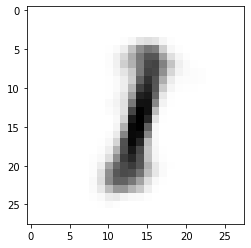

In [47]:
plt.imshow(res[2], cmap='gray_r')

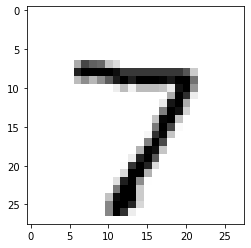

In [175]:
plt.imshow(x_test[0], cmap='gray_r')